In [205]:
%load_ext autoreload
%autoreload 2

import os
import re

import pysam
import pyranges as pr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import Bio.Seq

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
from handygenome import common
from handygenome.common import ChromDict, Vcfspec, Interval, IntervalList
from handygenome.variantplus.breakends import Breakends
from handygenome.variantplus.variantplus import VariantPlus, VariantPlusList
from handygenome.variantplus.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variantplus import vpfilter as libvpfilter
from handygenome.vcfeditor.initvcf import create_header

In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

# Basic Setups

In [4]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [6]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [7]:
BAMS = {
    sampletype: {
        sampleid: pysam.AlignmentFile(bampath) 
        for sampleid, bampath in bampathdic.items()
    }
    for sampletype, bampathdic in BAM_PATHS.items()
}

In [162]:
PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/reannot_220914'
PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL = dict()

for fname in os.listdir(PREVIOUS_WGS_REANNOT_TOPDIR):
    if fname.endswith('.annot.readstats.vcf.gz'):
        sampleid = fname.split('.')[0]
        if 'snv' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)
        elif 'indel' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)

# Testrun

In [723]:
import handygenome.plot.circos as libcircos
import handygenome.cnv.cnvreader as cnvreader
import handygenome.sv.svreader as svreader

In [729]:
vcf_path = PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV['LU-14']
vcf = VcfPlus(vcf_path, init_all_attrs=True)
variants_df = vcf.vplist.get_df()

In [727]:
segment_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza/14/sequenza_files/analysis_files/14_tumor_segments.txt'
segment_df = cnvreader.read_sequenza_segment(segment_path)

In [733]:
depth_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/quick_results/LU-14.tumor.100kbin.regions.bed.gz'
depth_df = cnvreader.read_depth_bed(depth_path)

In [731]:
sv_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/previous_sv_results/LU-14.SV_final.181230.txt.anv'
sv_df = svreader.previous_sv_reader(sv_path)

In [873]:
# chr1_points = np.linspace(0, CHROMDICT_HG19['1'], 4, endpoint=True)
# chr2_points = np.linspace(0, CHROMDICT_HG19['2'], 4, endpoint=True)
# chr3_points = np.linspace(0, CHROMDICT_HG19['3'], 4, endpoint=True)
# sectorlist = libcircos.SectorList(
#     chroms=['1', '2', '3'],
#     start0s=(int(x) for x in [chr1_points[1], chr2_points[1], chr3_points[1]]),
#     end0s=(int(x) for x in [chr1_points[2], chr2_points[2], chr3_points[2]]),
# )


# sectorlist = libcircos.SectorList(
#     chroms=['1', '2', '3'],
#     start0s=[0, 0, 0],
#     end0s=[CHROMDICT_HG19[x] for x in ['1', '2', '3']],
# )

# sectorlist = libcircos.SectorList(
#     chroms=['1', '2'],
#     start0s=[0, 0],
#     end0s=[CHROMDICT_HG19[x] for x in ['1', '2']],
# )

# sectorlist = libcircos.SectorList(
#     chroms=['1'],
#     start0s=[0],
#     end0s=[CHROMDICT_HG19[x] for x in ['1']],
# )

sectorlist = libcircos.SectorList(
    chroms=['1'],
    start0s=[27_849_231],
    end0s=[31_330_385],
)

In [890]:
circos = libcircos.Circos(refver='hg19', sectorlist=sectorlist, figsize=(20, 20))
# circos = libcircos.Circos(refver='hg19', sectorlist=None, figsize=(20, 20))

circos.draw_sector_titles(radial_pos=1.05)
# circos.draw_poslabels_within_sector(interspace_deg=5)
circos.draw_cytoband(refver='hg19', radial_range=(0.96, 1))
circos.draw_point_mutation(variants_df, size=5, radial_range=(0.8, 0.96))
circos.draw_copynumber(segment_df, radial_range=(0.64, 0.8))
circos.draw_depth(depth_df, radial_range=(0.48, 0.64), size=1)
circos.draw_breakends(sv_df, radial_pos=0.48)

In [891]:
circos.figure.suptitle('LU-14', x=0.5, y=1.10, fontsize=40)

Text(0.5, 1.1, 'LU-14')

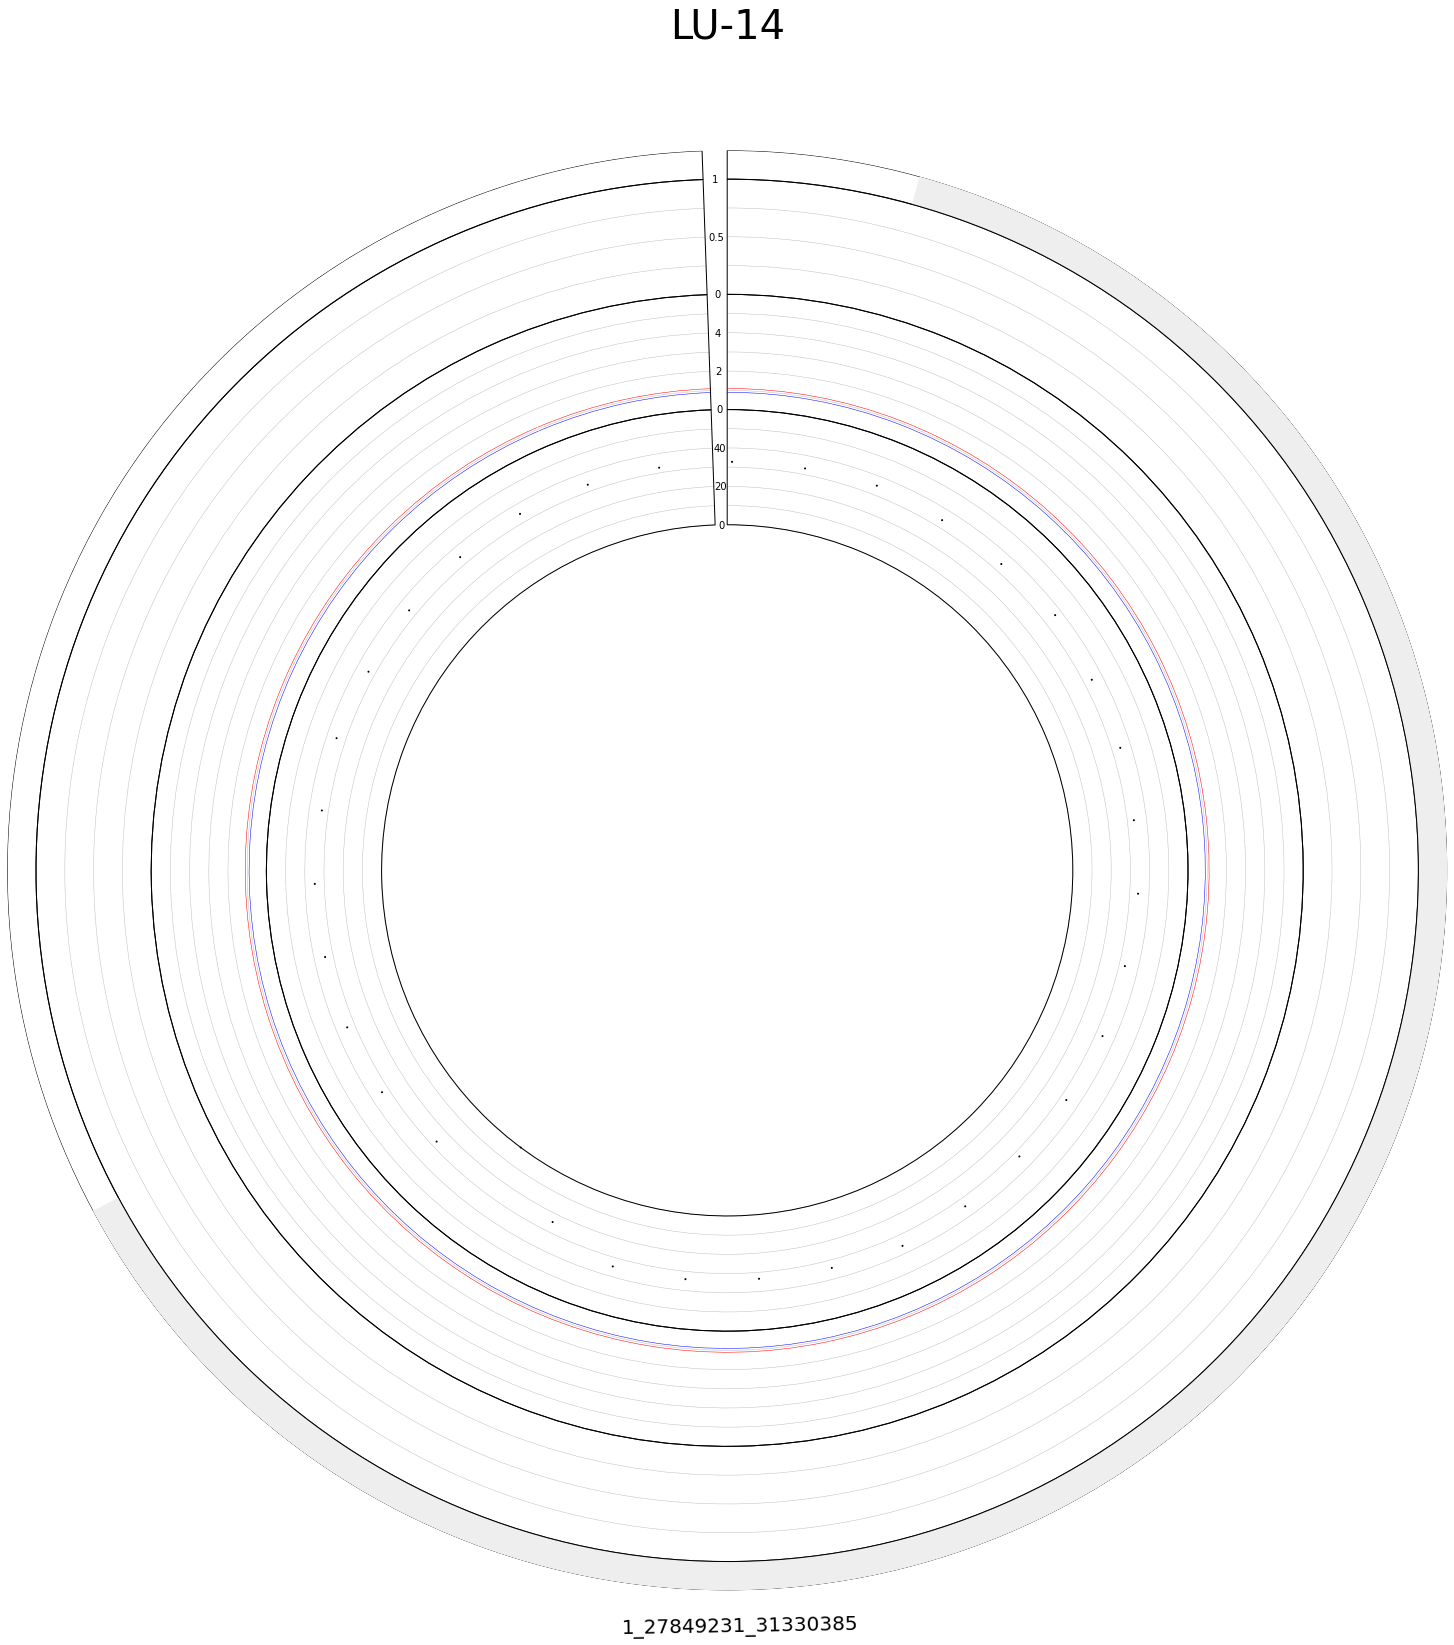

In [892]:
circos.figure